In [ ]:
%matplotlib inline

In [ ]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision.transforms as T
from torchvision.io import read_image


plt.rcParams["savefig.bbox"] = 'tight'
torch.manual_seed(1)


def show(imgs):
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = T.ToPILImage()(img.to('cpu'))
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

The :func:`~torchvision.io.read_image` function allows to read an image and
directly load it as a tensor



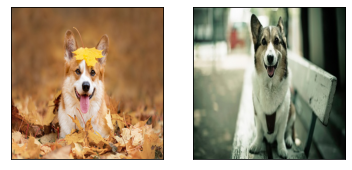

In [ ]:
dog1 = read_image("d33.jpeg")
dog2 = read_image("d22.jpeg")
show([dog1, dog2])

## Transforming images on GPU
Most transforms natively support tensors on top of PIL images (to visualize
the effect of the transforms, you may refer to see
`sphx_glr_auto_examples_plot_transforms.py`).
Using tensor images, we can run the transforms on GPUs if cuda is available!



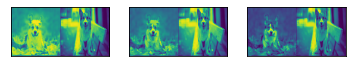

In [ ]:
from torchvision.utils import make_grid
from torchvision.io import read_image
from pathlib import Path



dog1_int = read_image("d33.jpeg")
dog2_int = read_image("d22.jpeg")
dog_list = [dog1_int, dog2_int]
# show([dog1, dog2])

grid = make_grid(dog_list)
show(grid)

## Scriptable transforms for easier deployment via torchscript
We now show how to combine image transformations and a model forward pass,
while using ``torch.jit.script`` to obtain a single scripted module.

Let's define a ``Predictor`` module that transforms the input tensor and then
applies an ImageNet model on it.



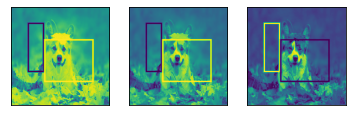

In [ ]:
from torchvision.models import resnet18, ResNet18_Weights

from torchvision.utils import draw_bounding_boxes


boxes = torch.tensor([[50, 50, 100, 200], [100, 100, 250, 230]], dtype=torch.float)
colors = ["blue", "yellow"]
result = draw_bounding_boxes(dog1_int, boxes, colors=colors, width=5)
show(result)

Now, let's define scripted and non-scripted instances of ``Predictor`` and
apply it on multiple tensor images of the same size



In [ ]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights


weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
transforms = weights.transforms()

images = [transforms(d) for d in dog_list]

model = fasterrcnn_resnet50_fpn(weights=weights, progress=False)
model = model.eval()

outputs = model(images)
print(outputs)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


[{'boxes': tensor([[ 89.4952,  55.4731, 209.5320, 269.8044],
        [133.5345, 171.2445, 152.5864, 209.3293],
        [  0.0000, 246.5527,  63.2976, 299.6316],
        [  5.9322,  18.3742, 292.1565, 300.0000],
        [  8.1482,  34.6867, 177.5874, 268.8335]], grad_fn=<StackBackward0>), 'labels': tensor([18, 32, 88, 65, 18]), 'scores': tensor([0.9772, 0.5709, 0.1185, 0.1181, 0.0567], grad_fn=<IndexBackward0>)}, {'boxes': tensor([[107.8313,   9.2955, 198.2909, 300.0000],
        [132.7521,  45.0298, 286.2872, 273.8199],
        [ 65.6687,  11.4130, 275.6167, 297.5723],
        [107.5805,  19.8820, 196.5318, 298.6017],
        [ 66.7999,  15.2400, 271.6652, 297.2292],
        [174.8153,  68.5671, 276.6860, 251.1556],
        [102.5285,  14.5649, 271.0656, 254.1931],
        [ 96.7236,  63.7068, 207.5018, 297.2143],
        [179.4656,  82.9531, 283.0251, 250.1187],
        [ 98.1229,  61.5331, 204.6763, 298.2354],
        [ 25.3942,  59.7934, 292.4037, 291.6426],
        [116.1977,  45.2

We can verify that the prediction of the scripted and non-scripted models are
the same:



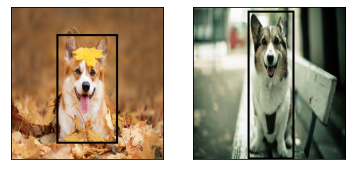

In [ ]:
score_threshold = .8
dogs_with_boxes = [
    draw_bounding_boxes(dog_int, boxes=output['boxes'][output['scores'] > score_threshold], width=4)
    for dog_int, output in zip(dog_list, outputs)
]
show(dogs_with_boxes)

Since the model is scripted, it can be easily dumped on disk and re-used



In [ ]:
from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights

weights = FCN_ResNet50_Weights.DEFAULT
transforms = weights.transforms(resize_size=None)

model = fcn_resnet50(weights=weights, progress=False)
model = model.eval()

batch = torch.stack([transforms(d) for d in dog_list])
output = model(batch)['out']
print(output.shape, output.min().item(), output.max().item())

Downloading: "https://download.pytorch.org/models/fcn_resnet50_coco-1167a1af.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet50_coco-1167a1af.pth


torch.Size([2, 21, 300, 300]) -5.7581868171691895 13.338006019592285


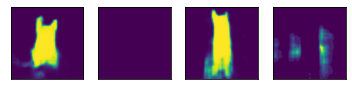

In [ ]:
sem_class_to_idx = {cls: idx for (idx, cls) in enumerate(weights.meta["categories"])}

normalized_masks = torch.nn.functional.softmax(output, dim=1)

dog_and_boat_masks = [
    normalized_masks[img_idx, sem_class_to_idx[cls]]
    for img_idx in range(len(dog_list))
    for cls in ('dog', 'boat')
]

show(dog_and_boat_masks)

shape = torch.Size([2, 300, 300]), dtype = torch.bool


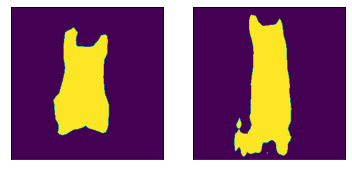

In [ ]:
class_dim = 1
boolean_dog_masks = (normalized_masks.argmax(class_dim) == sem_class_to_idx['dog'])
print(f"shape = {boolean_dog_masks.shape}, dtype = {boolean_dog_masks.dtype}")
show([m.float() for m in boolean_dog_masks])

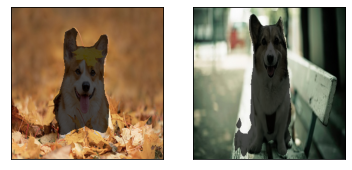

In [ ]:
from torchvision.utils import draw_segmentation_masks

dogs_with_masks = [
    draw_segmentation_masks(img, masks=mask, alpha=0.7)
    for img, mask in zip(dog_list, boolean_dog_masks)
]
show(dogs_with_masks)

dog1_masks shape = torch.Size([21, 300, 300]), dtype = torch.float32
dog1_all_classes_masks = torch.Size([21, 300, 300]), dtype = torch.bool


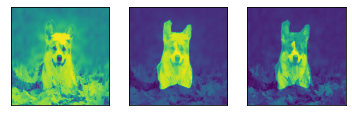

In [ ]:
num_classes = normalized_masks.shape[1]
dog1_masks = normalized_masks[0]
class_dim = 0
dog1_all_classes_masks = dog1_masks.argmax(class_dim) == torch.arange(num_classes)[:, None, None]

print(f"dog1_masks shape = {dog1_masks.shape}, dtype = {dog1_masks.dtype}")
print(f"dog1_all_classes_masks = {dog1_all_classes_masks.shape}, dtype = {dog1_all_classes_masks.dtype}")

dog_with_all_masks = draw_segmentation_masks(dog1_int, masks=dog1_all_classes_masks, alpha=.6)
show(dog_with_all_masks)

shape = torch.Size([21, 2, 300, 300]), dtype = torch.bool


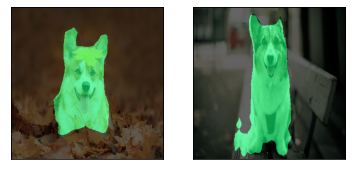

In [ ]:
class_dim = 1
all_classes_masks = normalized_masks.argmax(class_dim) == torch.arange(num_classes)[:, None, None, None]
print(f"shape = {all_classes_masks.shape}, dtype = {all_classes_masks.dtype}")
# The first dimension is the classes now, so we need to swap it
all_classes_masks = all_classes_masks.swapaxes(0, 1)

dogs_with_masks = [
    draw_segmentation_masks(img, masks=mask, alpha=.6)
    for img, mask in zip(dog_list, all_classes_masks)
]
show(dogs_with_masks)

In [ ]:
from torchvision.models.detection import maskrcnn_resnet50_fpn, MaskRCNN_ResNet50_FPN_Weights

weights = MaskRCNN_ResNet50_FPN_Weights.DEFAULT
transforms = weights.transforms()

images = [transforms(d) for d in dog_list]

model = maskrcnn_resnet50_fpn(weights=weights, progress=False)
model = model.eval()

output = model(images)
print(output)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


[{'boxes': tensor([[ 86.7660,  45.1605, 209.6600, 282.1666],
        [109.3620,  42.9770, 276.6212, 258.9271],
        [134.9785, 171.8401, 153.9888, 210.3399],
        [ 84.9728,  98.1982, 206.5068, 272.5945],
        [  0.6669, 250.8443,  66.7277, 299.3879],
        [ 76.3806, 134.2502, 211.9070, 268.2432]], grad_fn=<StackBackward0>), 'labels': tensor([18, 18, 32, 88, 88, 20]), 'scores': tensor([0.9881, 0.3820, 0.2101, 0.0906, 0.0868, 0.0597],
       grad_fn=<IndexBackward0>), 'masks': tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],


        [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000,

In [ ]:
dog1_output = output[0]
dog1_masks = dog1_output['masks']
print(f"shape = {dog1_masks.shape}, dtype = {dog1_masks.dtype}, "
      f"min = {dog1_masks.min()}, max = {dog1_masks.max()}")

shape = torch.Size([6, 1, 300, 300]), dtype = torch.float32, min = 0.0, max = 0.9998473525047302


In [ ]:
print("For the first dog, the following instances were detected:")
print([weights.meta["categories"][label] for label in dog1_output['labels']])

For the first dog, the following instances were detected:
['dog', 'dog', 'tie', 'teddy bear', 'teddy bear', 'sheep']


shape = torch.Size([6, 1, 300, 300]), dtype = torch.bool


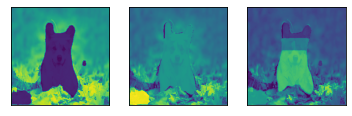

In [ ]:
proba_threshold = 0.5
dog1_bool_masks = dog1_output['masks'] > proba_threshold
print(f"shape = {dog1_bool_masks.shape}, dtype = {dog1_bool_masks.dtype}")

# There's an extra dimension (1) to the masks. We need to remove it
dog1_bool_masks = dog1_bool_masks.squeeze(1)

show(draw_segmentation_masks(dog1_int, dog1_bool_masks, alpha=0.9))

In [ ]:
print(dog1_output['scores'])

tensor([0.9881, 0.3820, 0.2101, 0.0906, 0.0868, 0.0597],
       grad_fn=<IndexBackward0>)


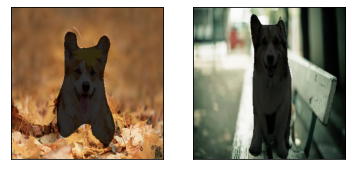

In [ ]:
score_threshold = .75

boolean_masks = [
    out['masks'][out['scores'] > score_threshold] > proba_threshold
    for out in output
]

dogs_with_masks = [
    draw_segmentation_masks(img, mask.squeeze(1))
    for img, mask in zip(dog_list, boolean_masks)
]
show(dogs_with_masks)

In [ ]:
from torchvision.models.detection import keypointrcnn_resnet50_fpn, KeypointRCNN_ResNet50_FPN_Weights
from torchvision.io import read_image
import torch
import torchvision.transforms as T

person_int = read_image( "person1.jpeg")

weights = KeypointRCNN_ResNet50_FPN_Weights.DEFAULT
transforms = weights.transforms()
def show(img):
    img = T.ToPILImage()(img.to('cpu'))
    plt.imshow(np.asarray(img))
    plt.axis('off')
    plt.show()

person_float = transforms(person_int)

model = keypointrcnn_resnet50_fpn(weights=weights, progress=False)
model = model.eval()

outputs = model([person_float])
print(outputs)

Downloading: "https://download.pytorch.org/models/keypointrcnn_resnet50_fpn_coco-fc266e95.pth" to /root/.cache/torch/hub/checkpoints/keypointrcnn_resnet50_fpn_coco-fc266e95.pth


[{'boxes': tensor([[280.1459,  24.9256, 382.4065, 279.4749]], grad_fn=<StackBackward0>), 'labels': tensor([1]), 'scores': tensor([0.9998], grad_fn=<IndexBackward0>), 'keypoints': tensor([[[298.1049,  61.6231,   1.0000],
         [299.3726,  56.5321,   1.0000],
         [294.3018,  57.8048,   1.0000],
         [313.3172,  47.1986,   1.0000],
         [313.3172,  47.1986,   1.0000],
         [344.1644,  65.0171,   1.0000],
         [316.2752,  70.9566,   1.0000],
         [367.4055, 102.7752,   1.0000],
         [315.0075, 111.6844,   1.0000],
         [371.6311, 142.2303,   1.0000],
         [300.2177, 147.3213,   1.0000],
         [336.5583, 146.8971,   1.0000],
         [316.2752, 147.7456,   1.0000],
         [323.8813, 202.0494,   1.0000],
         [297.6823, 193.5645,   1.0000],
         [361.0670, 261.4443,   1.0000],
         [311.6270, 249.1411,   1.0000]]], grad_fn=<CopySlices>), 'keypoints_scores': tensor([[14.2292, 15.5902, 10.9889, 14.6258,  5.7135,  9.1892,  6.5201, 11.1554

In [ ]:
kpts = outputs[0]['keypoints']
scores = outputs[0]['scores']

print(kpts)
print(scores)

tensor([[[298.1049,  61.6231,   1.0000],
         [299.3726,  56.5321,   1.0000],
         [294.3018,  57.8048,   1.0000],
         [313.3172,  47.1986,   1.0000],
         [313.3172,  47.1986,   1.0000],
         [344.1644,  65.0171,   1.0000],
         [316.2752,  70.9566,   1.0000],
         [367.4055, 102.7752,   1.0000],
         [315.0075, 111.6844,   1.0000],
         [371.6311, 142.2303,   1.0000],
         [300.2177, 147.3213,   1.0000],
         [336.5583, 146.8971,   1.0000],
         [316.2752, 147.7456,   1.0000],
         [323.8813, 202.0494,   1.0000],
         [297.6823, 193.5645,   1.0000],
         [361.0670, 261.4443,   1.0000],
         [311.6270, 249.1411,   1.0000]]], grad_fn=<CopySlices>)
tensor([0.9998], grad_fn=<IndexBackward0>)


In [ ]:
detect_threshold = 0.75
idx = torch.where(scores > detect_threshold)
keypoints = kpts[idx]

print(keypoints)

tensor([[[298.1049,  61.6231,   1.0000],
         [299.3726,  56.5321,   1.0000],
         [294.3018,  57.8048,   1.0000],
         [313.3172,  47.1986,   1.0000],
         [313.3172,  47.1986,   1.0000],
         [344.1644,  65.0171,   1.0000],
         [316.2752,  70.9566,   1.0000],
         [367.4055, 102.7752,   1.0000],
         [315.0075, 111.6844,   1.0000],
         [371.6311, 142.2303,   1.0000],
         [300.2177, 147.3213,   1.0000],
         [336.5583, 146.8971,   1.0000],
         [316.2752, 147.7456,   1.0000],
         [323.8813, 202.0494,   1.0000],
         [297.6823, 193.5645,   1.0000],
         [361.0670, 261.4443,   1.0000],
         [311.6270, 249.1411,   1.0000]]], grad_fn=<IndexBackward0>)


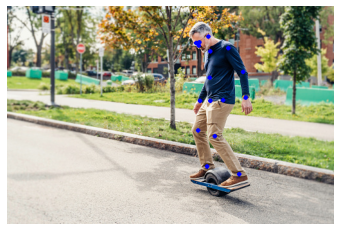

In [ ]:
from torchvision.utils import draw_keypoints

res = draw_keypoints(person_int, keypoints, colors="blue", radius=3)
show(res)

In [ ]:

coco_keypoints = [
    "nose", "left_eye", "right_eye", "left_ear", "right_ear",
    "left_shoulder", "right_shoulder", "left_elbow", "right_elbow",
    "left_wrist", "right_wrist", "left_hip", "right_hip",
    "left_knee", "right_knee", "left_ankle", "right_ankle",
]

In [ ]:
connect_skeleton = [
    (0, 1), (0, 2), (1, 3), (2, 4), (0, 5), (0, 6), (5, 7), (6, 8),
    (7, 9), (8, 10), (5, 11), (6, 12), (11, 13), (12, 14), (13, 15), (14, 16)
]

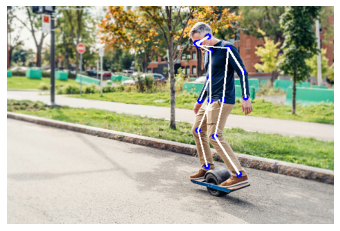

In [ ]:
res = draw_keypoints(person_int, keypoints, connectivity=connect_skeleton, colors="blue", radius=4, width=3)
show(res)